## Attention Model  (10 pt)

Credit to https://github.com/yandexdataschool/nlp_course/blob/2023/week04_seq2seq/practice_and_homework_pytorch.ipynb

In previous notebook we composed encoder-decoder recurrent neural networks and applied it to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


## Our task today to add additive attention


In [1]:
#We'll use data from https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench

In [2]:
#!kaggle datasets download -d devicharith/language-translation-englishfrench

In [3]:
#!unzip language-translation-englishfrench.zip

In [4]:
#%conda install torch>=1.3.0
#%conda install subword-nmt &> log
#!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
#!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [5]:
import csv
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.fr', 'w') as f_dst:
  with open('eng_-french.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    for line in csv_reader:
        src_line, dst_line = line[0], line[1]
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'fr']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:05<00:00, 1579.63it/s]


In [6]:
bpe['en'].process_line('A quick brown fox jumps over a lazy dog')

'A quick brown fox ju@@ mps over a lazy dog'

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_inp = np.array(open('./train.bpe.fr').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: chez quel gla@@ cier allez - vous ?
out: which ice cream shop are you going to ?

inp: il fallait s ' y attendre .
out: it was to be expected .

inp: soyez dis@@ cr@@ ète !
out: be discreet .



In [9]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # f'cuda:{2}' if torch.cuda.is_available() else 'cpu' #0 -is GPU2, 1 is GPU3, 3 is GPU1, 4 is 4 5 is GPU5,

In [12]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size) #connection between encoder and decoder
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        # print((inp != self.inp_voc.eos_ix).to(torch.int64))
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start] 

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        # prev_gru0_state = prev_state[0]
        [prev_gru0_state, ] = prev_state

        prev_token_embs = self.emb_out(prev_tokens)

        new_gru_activations = self.dec0(prev_token_embs, prev_gru0_state)
        new_dec_state = [new_gru_activations]
        output_logits = self.logits(new_gru_activations)

        return new_dec_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


### Training loss

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [13]:

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out) #

    loss = F.cross_entropy(logits_seq.permute(0, 2, 1), out, reduction='none')

    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return (loss*mask).sum() / mask.sum()

In [14]:
model = BasicModel(inp_voc, out_voc, emb_size=64, hid_size=128).to(device)
dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(6.6972, device='cuda:0', grad_fn=<DivBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [15]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [16]:
compute_bleu(model, dev_inp, dev_out)

0.00139860767561822

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (1 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [17]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        # create trainable paramteres like this:
        #self.<PARAMETER_NAME> = nn.Parameter(<INITIAL_VALUES>, requires_grad=True)
        
        self.linear_enc = nn.Linear(enc_size, hid_size, bias=False)
        self.linear_dec = nn.Linear(dec_size, hid_size, bias=False)
        self.linear_out = nn.Linear(hid_size, 1, bias=False)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits
        logits = self.linear_out(self.activ(self.linear_enc(enc) + self.linear_dec(dec.unsqueeze(1))))

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        logits = torch.where(inp_mask == 0, -torch.inf, logits.squeeze(-1))

        # Compute attention probabilities (softmax)
        probs = F.softmax(logits, dim=-1)

        # Compute attention response using enc and probs
        attn = torch.sum(enc * probs.unsqueeze(-1), dim=1)

        return attn, probs

### Seq2seq model with attention

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [18]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        #<YOUR CODE: initialize layers>
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)
        
        self.attention = AttentionLayer(name, hid_size, hid_size, attn_size)
        self.decoder0 = nn.GRUCell(emb_size + hid_size, hid_size)
        
        self.logits = nn.Linear(hid_size, len(out_voc))
        
        self.name = name

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """

        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, _ = self.enc0(inp_emb)

        # apply attention layer from initial decoder hidden state
        mask = self.out_voc.compute_mask(inp)
        
        dec_start = torch.zeros(batch_size, self.hid_size, device=inp.device)
        first_attn, first_attn_probas = self.attention(enc_seq, dec_start, mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        return [dec_start, enc_seq, mask, first_attn, first_attn_probas]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        # prev_gru0_state = prev_state[0]
        prev_dec_state, enc_seq, mask, prev_attn, prev_attn_probas = prev_state

        prev_token_embs = self.emb_out(prev_tokens)

        new_dec_state = self.decoder0(torch.cat([prev_token_embs, prev_attn], dim=-1), prev_dec_state)
        
        output_logits = self.logits(new_dec_state)
        
        attn, attn_probas = self.attention(enc_seq, new_dec_state, mask)

        return [new_dec_state, enc_seq, mask, attn, attn_probas], output_logits

### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [22]:
model = AttentiveModel('attentive', inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128).to(device)

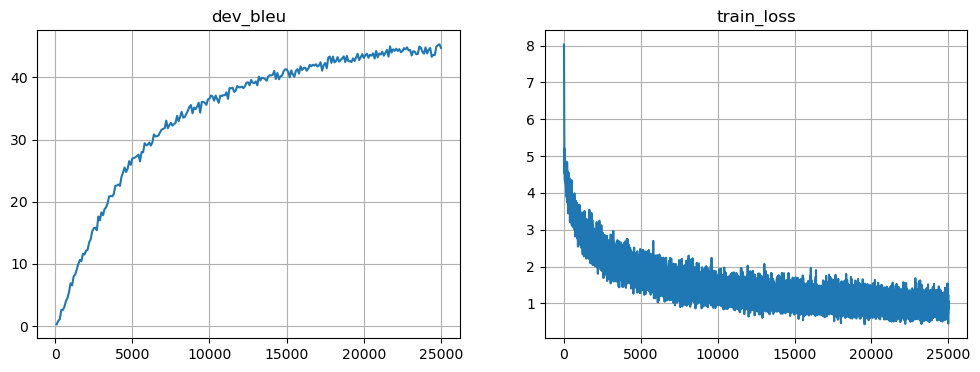

Mean loss=0.857


100%|██████████| 25000/25000 [14:56<00:00, 27.88it/s]


In [23]:
#<YOUR CODE: create AttentiveModel and training utilities>
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    #
    loss_t = compute_loss(model, batch_inp, batch_out)
    opt.zero_grad()
    loss_t.backward()
    opt.step()
    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batch

In [26]:

for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()
final_bleu = compute_bleu(model, dev_inp, dev_out)
print("Final BLEU score:", final_bleu)

prends place !
take a seat .

elle ne fait pas la différence entre le bien et le mal .
she does not break the difference and i ' m .

ne discu@@ te pas au sujet de ma famille !
don ' t talk about you for my family .

au lieu de prendre des notes , j ' ai passé tout le cours à gri@@ bou@@ iller .
at the internet of taking notes , i spent all the lottery .

dis à tom que je suis en colère .
tell tom i ' m angry .

laissez - moi gérer ça !
let me handle this .

Final BLEU score: 44.736965907285914


In [ ]:
#torch.save(model.state_dict(), 'attention_batch32.pt')

### Visualizing model attention (1 points)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please leave them in the notebook or save  bokeh figures and add to your sumbission. You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [28]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

Loading BokehJS ...

In [29]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)


In [30]:
probs = [states[i][-1] for i in range(len(states))]

In [31]:
attention_probs = np.stack([state[-1].cpu().detach().numpy() for state in states], axis=1)

In [32]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])

# Does it look fine already? don't forget to save images for anytask!

__Note:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

## Implement Two different archetectures with attention (8 points)

We want you to find the best model for the task. Use everything you know.

* add attention after RNN or as a hidden state input
* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

Describe what you tried and what results you obtained in a short report.